# **Assignment 3**
*By - Ayush kumar (MS19038)*

In [ ]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import math

In [ ]:
def datasplit(filepath):
    comp_data = []
    with open(filepath, 'r') as f:
        reader = csv.reader(f)
        next(reader, None)
        for row in reader:
            com_data = [int(p) for p in row[:]]
            comp_data.append(com_data)
    comp_data = np.array(comp_data)    
    np.random.shuffle(comp_data)
    x = comp_data[:, 1:]
    y = comp_data[:, 0]
    return x, y

In [ ]:
filepath = '/kaggle/input/finaldata/mnist_train.csv'
x, y = datasplit(filepath)

# OOP implementation MLP 
This code is the general code which will work for any number of hidden layers

**Explaination of MLP class**

__init__: initializes the model with a given set of layer sizes and activation functions.

cross_entropy: computes the cross-entropy loss between predicted and actual labels.

derivative: computes the derivative of a given activation function.

activations: computes the activation function for a given input.

forward: performs a forward pass through the neural network to compute the activations of each layer.

get_accuracy: computes the accuracy of the model based on the predicted labels.

backward: computes the gradients for each weight and bias in the network using backpropagation.

train_multi_layer_nn: trains the model using stochastic gradient descent with momentum.

predict: predicts the output of the model for a given input.

In [ ]:
class MLP:
    def __init__(self, layer_sizes, activation_ls):
        self.layer_sizes = layer_sizes
        self.activation_ls = activation_ls
        self.weights = []
        self.biases = []
        for i in range(len(layer_sizes) - 1):
            self.weights.append(np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(1. / layer_sizes[i + 1]))
            self.biases.append(np.random.randn(1, layer_sizes[i+1]) * np.sqrt(1. / layer_sizes[i+1]))
    
    
    def cross_entropy(self, y_probs, y_true, epsilon = 1e-12):
        m = y_true.shape[0]
        y_one_hot = np.eye(10)[y_true]
        y_probs = np.clip(y_probs, epsilon, 1.-epsilon)
        return -np.mean(np.sum(y_one_hot * np.log(y_probs), axis = 0))
    
    def derivative(self, type, x):
        if type.lower() == 'sigmoid':
            s = self.activations('sigmoid', x)
            return s * (1 - s)
        elif type.lower() == 'relu':
            return (x > 0).astype(float)
        elif type.lower() == 'tanh':
            return 1 - np.square(np.tanh(x))
        elif type.lower() == 'softmax':
            dZ = np.exp(x) / sum(np.exp(x)) * (1. - np.exp(x) / sum(np.exp(x)))
            return dZ

    def activations(self, type, x):
        if type.lower() == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        elif type.lower() == 'relu':
            return np.maximum(0, x)
        elif type.lower() == 'tanh':
            return np.tanh(x)
        elif type.lower() == 'softmax':
            exp_x = np.exp(x)
            return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def forward(self, x):
        a = x
        activation = [x]
        zs = []

        for i in range(len(self.layer_sizes) - 1):
            z = (np.dot(a, self.weights[i]) + self.biases[i])
            #z = z/np.max(z)
            a = self.activations(self.activation_ls[i], z)
            activation.append(a)
            zs.append(z)

        return activation, zs
    
    def get_accuracy(self, y_prob):
        y_pred = y_prob.argmax(axis = 1)
        return np.sum(y_pred == y) / y.size
    
    def backward(self, x, y, activation, zs):
        m = x.shape[0]
        delta = activation[-1] - np.eye(10)[y]

        dw = np.dot(activation[-2].T, delta) / m
        db = np.sum(delta, axis=0, keepdims=True) / m

        grad_w = [dw]
        grad_b = [db]

        for i in range(2, len(activation)):
            a = activation[-i - 1]
            z = zs[-i]

            delta = np.dot(delta, self.weights[-i + 1].T) * self.derivative(self.activation_ls[-i], z)

            dw = np.dot(a.T, delta) / m
            db = np.sum(delta, axis=0, keepdims=True) / m

            grad_w.append(dw)
            grad_b.append(db)
        
        grad_w.reverse()
        grad_b.reverse()

        return grad_w, grad_b
    

    def train_multi_layer_nn(self, X, Y, learning_rate, momentum, epochs):
        velocity_weights = [np.zeros(w.shape) for w in self.weights]
        velocity_biases = [np.zeros(b.shape) for b in self.biases]
        losses = []
        accuracies = []
        
        for epoch in range(epochs):
            activation, zs = self.forward(X)
            accuracy = self.get_accuracy(activation[-1])
            accuracies.append(accuracy)
            losses.append(self.cross_entropy(activation[-1], Y))
            grad_w, grad_b = self.backward(X, Y, activation, zs)
            velocity_weights = [momentum * v - learning_rate * gw for v, gw in zip(velocity_weights, grad_w)]
            velocity_biases = [momentum * v - learning_rate * gb for v, gb in zip(velocity_biases, grad_b)]
            self.weights = [w + v for w, v in zip(self.weights, velocity_weights)]
            self.biases = [b + v for b, v in zip(self.biases, velocity_biases)]

            if epoch % 100 == 0:
                print('At epoch: {}, the accuracy is: {}'.format(epoch,accuracy))

        plt.plot(losses)
        plt.title('Error')
        plt.show()
        plt.title('Accuracy of prediction')
        plt.plot(accuracies)
        plt.show()
        return self.weights, self.biases
    
    def predict(self, x, y):
        a = x
        activation = [x]
        zs = []

        for i in range(len(self.layer_sizes) - 1):
            z = (np.dot(a, self.weights[i]) + self.biases[i])
            a = self.activations(self.activation_ls[i], z)
            activation.append(a)
            zs.append(z)
        
        y_prob = activation[-1]
        y_pred = y_prob.argmax(axis = 1)

        return np.sum(y_pred == y) / y.size


# Problem 2
A zero layer model

At epoch: 0, the accuracy is: 0.0762
At epoch: 100, the accuracy is: 0.2059
At epoch: 200, the accuracy is: 0.3474833333333333
At epoch: 300, the accuracy is: 0.45693333333333336
At epoch: 400, the accuracy is: 0.5316333333333333


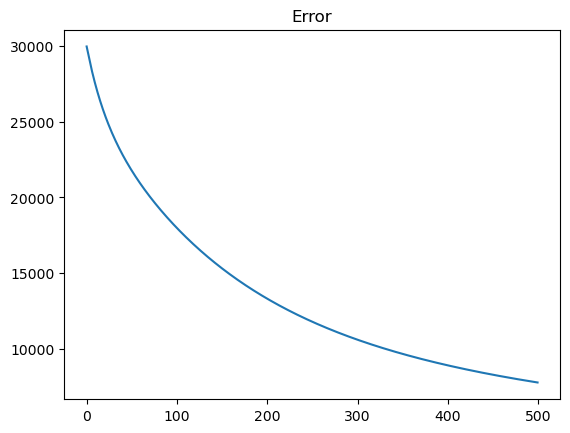

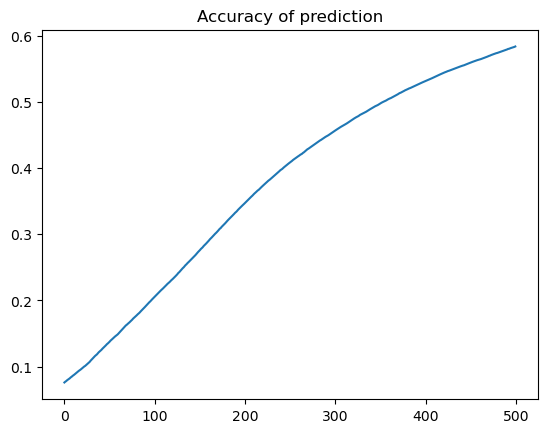

In [ ]:
X = x
Y = y
activation_ls = ['softmax']
layer_sizes = [X.shape[1], 10]
learning_rate = 0.01
momentum = 0.1
epochs = 500

net = MLP(layer_sizes, activation_ls)
wts, b = net.train_multi_layer_nn(X, Y, learning_rate, momentum, epochs)

# Problem 3
Single layer.

At epoch: 0, the accuracy is: 0.08631666666666667
At epoch: 100, the accuracy is: 0.12213333333333333
At epoch: 200, the accuracy is: 0.20285
At epoch: 300, the accuracy is: 0.27076666666666666
At epoch: 400, the accuracy is: 0.32305


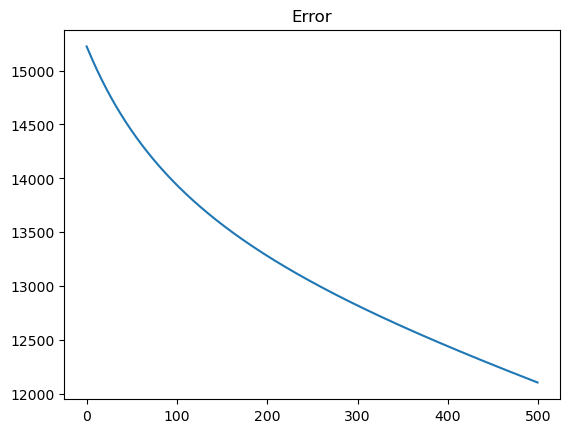

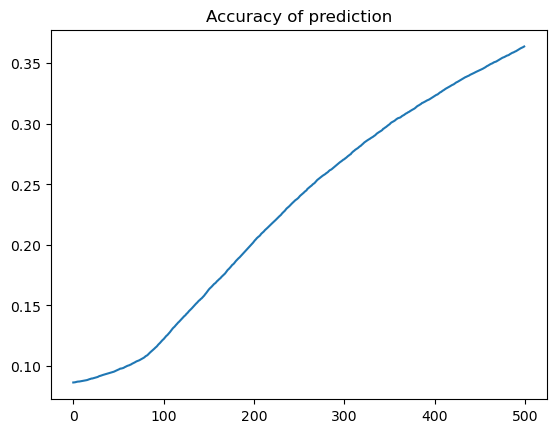

In [ ]:
X = x
Y = y
activation_ls = ['sigmoid', 'softmax']
layer_sizes = [X.shape[1], 15, 10]
learning_rate = 0.01
momentum = 0.1
epochs = 500

net = MLP(layer_sizes, activation_ls)
wts, b = net.train_multi_layer_nn(X, Y, learning_rate, momentum, epochs)

# Problem 4
double layer network

At epoch: 0, the accuracy is: 0.14128333333333334
At epoch: 100, the accuracy is: 0.6996
At epoch: 200, the accuracy is: 0.7933333333333333
At epoch: 300, the accuracy is: 0.8257333333333333
At epoch: 400, the accuracy is: 0.8442


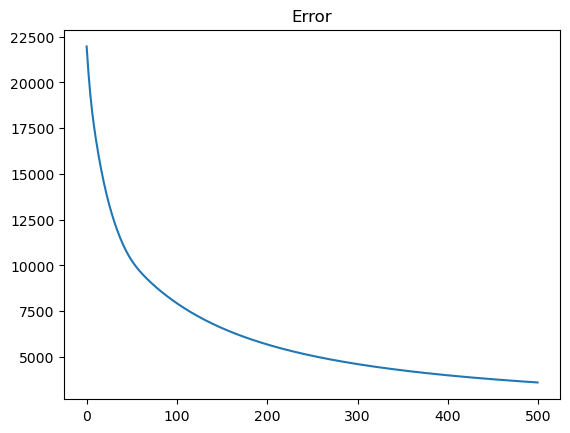

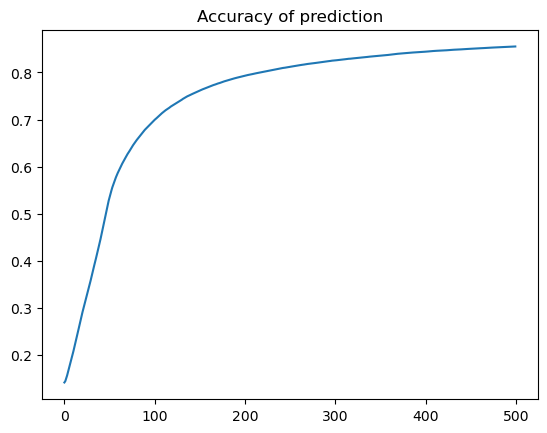

In [ ]:
X = x
Y = y
activation_ls = ['tanh', 'sigmoid', 'softmax']
layer_sizes = [X.shape[1], 280, 176, 10]
learning_rate = 0.01
momentum = 0.1
epochs = 500

net = MLP(layer_sizes, activation_ls)
wts, b = net.train_multi_layer_nn(X, Y, learning_rate, momentum, epochs)

# Problem 5 & 6

Taking 50k data as train and 10k as test data.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


At epoch: 0, the accuracy is: 0.0
At epoch: 100, the accuracy is: 0.0
At epoch: 200, the accuracy is: 0.0
At epoch: 300, the accuracy is: 0.0
At epoch: 400, the accuracy is: 0.0


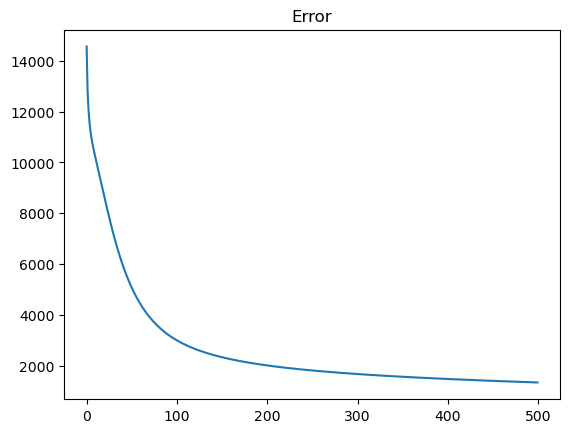

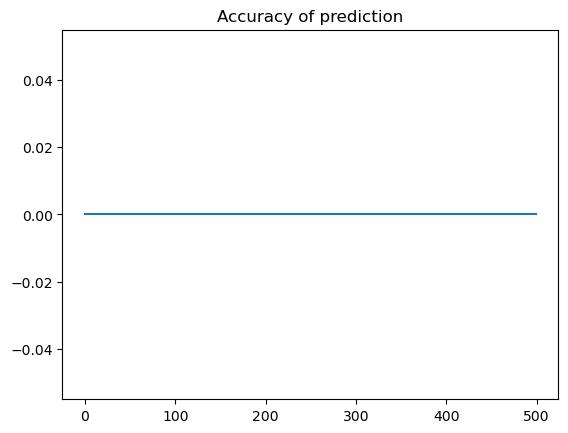

In [ ]:
X_norm = x
X = X_norm[:50000,:]
Y = y[:50000]

X_test = X_norm[50000:,:]
Y_test = y[50000:]

activation_ls = ['relu', 'relu', 'sigmoid', 'softmax']
layer_sizes = [X.shape[1], 150, 120, 60, 10]
learning_rate = 0.1
momentum = 0.1
epochs = 500

net = MLP(layer_sizes, activation_ls)
wts, b = net.train_multi_layer_nn(X, Y, learning_rate, momentum, epochs)


In [ ]:
accuracy = net.predict(X_test, Y_test)
accuracy

0.9192